### An illustration for complex shaped domain

+ The distance function and the boundary constraint that I used in preliminary experiments is not correct.(steep gradient)
<small>

**2D Poisson Equation example**:

The governing equation for the 2D Poisson problem is:
$$
- \frac{\partial^2 u}{\partial x^2}(x, y) - \frac{\partial^2 u}{\partial y^2}(x, y) = 1, \quad (x, y) \in \Omega,
$$

with Dirichlet boundary conditions:

$$
u(x, y) = 0, \quad (x, y) \in \partial \Omega.
$$

The computational domain $\Omega$ consists of:

1.  A circle centered at $(1,1)$ with radius $r = 1$:
    $$
    \Omega_{\text{circle}} = \left\{(x, y) \mid (x - 1)^2 + (y - 1)^2 \leq 1 \right\}.
    $$
2.  A rectangle spanning $[1,3]$ in $x$ and $\left[\frac{1}{2}, \frac{3}{2}\right]$ in $y$:
    $$
    \Omega_{\text{rect}} = \left\{(x, y) \mid x \in [1,3], \, y \in \left[\frac{1}{2}, \frac{3}{2}\right] \right\}.
    $$
    $$
    \Gamma = \Omega_{\text{rect}} \cap \Omega_{\text{circle}}.
    $$
    $$
    \Omega = \Omega_{\text{circle}} \cup \Omega_{\text{rect}}.
    $$


In [1]:
import jax, jax.numpy as jnp, jax.random as jr
import equinox as eqx, optax
import matplotlib.pyplot as plt
from tqdm.notebook import trange

# ---------- 调参区 ----------
WIDTH, DEPTH = 128, 5
ALPHA        = 25.0
LR, EPOCHS   = 1e-3, 3_000
N_COL, BATCH = 20_000, 1_024
SEED         = 0            # 你刚用的 0
# ----------------------------
'''
# ——— 几何: circle ∪ rectangle —
C, R = jnp.array([1.,1.]), 1.
R_MIN, R_MAX = jnp.array([1.,.5]), jnp.array([3.,1.5])

d_circle = lambda p: R - jnp.linalg.norm(p - C, axis=-1)
def d_rect(p):
    dx1, dx2 = p[...,0]-R_MIN[0], R_MAX[0]-p[...,0]
    dy1, dy2 = p[...,1]-R_MIN[1], R_MAX[1]-p[...,1]
    return jnp.minimum(jnp.minimum(dx1,dx2), jnp.minimum(dy1,dy2))
d_union = lambda p: jnp.maximum(d_circle(p), d_rect(p))
phi     = lambda p: jnp.where(d_union(p)>0, 1.-jnp.exp(-ALPHA*d_union(p)), 0.)
inside  = lambda p: d_union(p) > 0'''


'\n# ——— 几何: circle ∪ rectangle —\nC, R = jnp.array([1.,1.]), 1.\nR_MIN, R_MAX = jnp.array([1.,.5]), jnp.array([3.,1.5])\n\nd_circle = lambda p: R - jnp.linalg.norm(p - C, axis=-1)\ndef d_rect(p):\n    dx1, dx2 = p[...,0]-R_MIN[0], R_MAX[0]-p[...,0]\n    dy1, dy2 = p[...,1]-R_MIN[1], R_MAX[1]-p[...,1]\n    return jnp.minimum(jnp.minimum(dx1,dx2), jnp.minimum(dy1,dy2))\nd_union = lambda p: jnp.maximum(d_circle(p), d_rect(p))\nphi     = lambda p: jnp.where(d_union(p)>0, 1.-jnp.exp(-ALPHA*d_union(p)), 0.)\ninside  = lambda p: d_union(p) > 0'

In [2]:
# --- JAX Configuration ---
jax.config.update("jax_enable_x64", True) # For 64-bit precision

# --- Geometric Parameters (as JAX arrays or Python constants) ---
# Circle defining Omega_circle
CIRCLE_CENTER_JAX = jnp.array([1.0, 1.0])
CIRCLE_RADIUS_JAX = 1.0

# Rectangle defining Omega_rect
RECT_X_MIN_JAX, RECT_X_MAX_JAX = 1.0, 3.0
RECT_Y_MIN_JAX, RECT_Y_MAX_JAX = 0.5, 1.5

# Precise Intersection Points (calculated as before)
SQRT_0_75 = jnp.sqrt(0.75) # sqrt(3)/2
X_INTERSECT_LEFT_JAX = 1.0 - SQRT_0_75
X_INTERSECT_RIGHT_JAX = 1.0 + SQRT_0_75

P_LT_JAX = jnp.array([X_INTERSECT_LEFT_JAX, RECT_Y_MAX_JAX])
P_RT_JAX = jnp.array([X_INTERSECT_RIGHT_JAX, RECT_Y_MAX_JAX])
P_LB_JAX = jnp.array([X_INTERSECT_LEFT_JAX, RECT_Y_MIN_JAX])
P_RB_JAX = jnp.array([X_INTERSECT_RIGHT_JAX, RECT_Y_MIN_JAX])
P_RECT_TR_JAX = jnp.array([RECT_X_MAX_JAX, RECT_Y_MAX_JAX])
P_RECT_BR_JAX = jnp.array([RECT_X_MAX_JAX, RECT_Y_MIN_JAX])

# --- Definitions for the 6 Boundary Primitives ---
# Segments: list of tuples, each tuple is (p1_jax_array, p2_jax_array)
PRIMITIVE_SEGMENTS_JAX = [
    (P_RT_JAX, P_RECT_TR_JAX),      # S1: Top-Right
    (P_RECT_TR_JAX, P_RECT_BR_JAX), # S2: Right Vertical
    (P_RECT_BR_JAX, P_RB_JAX)       # S3: Bottom-Right
]

# Arcs: list of dicts, each dict contains center, radius, and endpoints (ep1, ep2) for t-function
PRIMITIVE_ARCS_JAX = [
    {'center': CIRCLE_CENTER_JAX, 'radius': CIRCLE_RADIUS_JAX, 'ep1': P_RT_JAX, 'ep2': P_LT_JAX, 'id': 'A1_Top'},
    {'center': CIRCLE_CENTER_JAX, 'radius': CIRCLE_RADIUS_JAX, 'ep1': P_LT_JAX, 'ep2': P_LB_JAX, 'id': 'A2_Left'},
    {'center': CIRCLE_CENTER_JAX, 'radius': CIRCLE_RADIUS_JAX, 'ep1': P_LB_JAX, 'ep2': P_RB_JAX, 'id': 'A3_Bottom'}
]

# R-function parameter
M_R_FUNCTION_EXP = 4.0
EPSILON = 1e-9 # Small number to prevent division by zero or log(0) issues with phi_i

# --- JAX-compatible ADF (phi) functions ---

@jax.jit
def _func_f_val_segment_jax(point, p1, p2, segment_L_plus_eps):
    # segment_L_plus_eps is L + epsilon to avoid division by zero if L is tiny
    x, y = point[0], point[1]
    x1, y1 = p1[0], p1[1]
    x2, y2 = p2[0], p2[1]
    numerator = (x - x1) * (y2 - y1) - (y - y1) * (x2 - x1)
    return numerator / segment_L_plus_eps

@jax.jit
def _func_t_val_segment_jax(point, segment_L_plus_eps, xc_segment):
    x, y = point[0], point[1]
    xc_x, xc_y = xc_segment[0], xc_segment[1]
    norm_x_minus_xc_sq = (x - xc_x)**2 + (y - xc_y)**2
    L_div_2_sq = (segment_L_plus_eps / 2)**2 # Use segment_L_plus_eps here too for consistency if L was 0
    return (1 / segment_L_plus_eps) * (L_div_2_sq - norm_x_minus_xc_sq)

@jax.jit
def _calculate_phi_from_ft_jax(f_val, t_val):
    varphi_sq_arg = t_val**2 + f_val**4
    varphi = jnp.sqrt(jnp.maximum(0., varphi_sq_arg))

    phi_term2_num = varphi - t_val
    phi_term2_sq = (phi_term2_num / 2)**2
    phi_sq_arg = f_val**2 + phi_term2_sq
    
    # Ensure non-negative argument for sqrt, effectively abs for very small negatives
    phi_val = jnp.sqrt(jnp.maximum(0., phi_sq_arg))
    return phi_val

@jax.jit
def get_phi_for_segment_primitive_jax(point, p1, p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    L_sq = dx**2 + dy**2
    
    # Handle degenerate segment (L=0) carefully
    # If L is very small, f and t can become very large.
    # The original Formula 6 phi might not be well-behaved for a point.
    # For PINNs, distance to point is ||point - p1||.
    # We assume segments have non-zero length here based on geometry.
    segment_L = jnp.sqrt(L_sq)
    segment_L_plus_eps = segment_L + EPSILON # Avoid division by exactly zero

    xc_segment = (p1 + p2) / 2.0
    
    f_val = _func_f_val_segment_jax(point, p1, p2, segment_L_plus_eps)
    t_val = _func_t_val_segment_jax(point, segment_L_plus_eps, xc_segment)
    return _calculate_phi_from_ft_jax(f_val, t_val)

@jax.jit
def _f_for_arc_primitive_jax(point, center, radius): # User-defined f for arc
    # Ensure radius is not zero if it's a parameter
    radius_plus_eps = radius + EPSILON
    dist_sq_to_center = jnp.sum((point - center)**2)
    return (radius**2 - dist_sq_to_center) / (2 * radius_plus_eps)

@jax.jit
def _t_for_arc_primitive_jax(point, endpoint1, endpoint2): # User-defined t for arc
    p1x, p1y = endpoint1[0], endpoint1[1]
    p2x, p2y = endpoint2[0], endpoint2[1]
    px, py = point[0], point[1]

    dx_chord = p2x - p1x
    dy_chord = p2y - p1y
    L_chord_sq = dx_chord**2 + dy_chord**2
    
    L_chord = jnp.sqrt(L_chord_sq)
    L_chord_plus_eps = L_chord + EPSILON

    numerator = (px - p1x) * dy_chord - (py - p1y) * dx_chord
    return numerator / L_chord_plus_eps
    
@jax.jit
def get_phi_for_arc_primitive_jax(point, center, radius, arc_ep1, arc_ep2):
    f_val = _f_for_arc_primitive_jax(point, center, radius)
    t_val = _t_for_arc_primitive_jax(point, arc_ep1, arc_ep2)
    return _calculate_phi_from_ft_jax(f_val, t_val)

@jax.jit
def phi_total_method_A_jax(p_array):
    """
    Calculates the combined ADF using Method A for the 6 boundary primitives.
    p_array: A JAX array representing the point (x,y).
    """
    phi_values = jnp.array([]) # Initialize an empty JAX array

    # Phi for segments
    for p1, p2 in PRIMITIVE_SEGMENTS_JAX:
        phi_s = get_phi_for_segment_primitive_jax(p_array, p1, p2)
        phi_values = jnp.append(phi_values, phi_s)
            
    # Phi for arcs
    for arc_params in PRIMITIVE_ARCS_JAX:
        phi_a = get_phi_for_arc_primitive_jax(
            p_array, 
            arc_params['center'], 
            arc_params['radius'],
            arc_params['ep1'], 
            arc_params['ep2']
        )
        phi_values = jnp.append(phi_values, phi_a)
        
    # R-Function Combination
    # Add epsilon to phi_values before taking inverse power to avoid 1/0 for points on boundary
    phi_values_plus_eps = phi_values + EPSILON 
    sum_inv_phi_m = jnp.sum((1.0 / phi_values_plus_eps)**M_R_FUNCTION_EXP)
    
    # If any original phi_value was very close to 0, the total phi should be 0
    # The epsilon handles the direct 1/0 but sum_inv_phi_m could still be huge
    # This jnp.where handles points exactly on the boundary making phi_total 0
    # For points very near boundary, sum_inv_phi_m is large, result is small.
    
    # A more robust way to handle points on boundary:
    # is_on_boundary = jnp.any(phi_values < EPSILON) # Check if any phi_i is near zero
    # combined_phi = jnp.where(
    #     is_on_boundary,
    #     0.0,
    #     sum_inv_phi_m**(-1.0 / M_R_FUNCTION_EXP)
    # )
    # However, the epsilon in phi_values_plus_eps should prevent NaNs from 1/0.
    # The result will naturally be small if any phi_values_plus_eps is small.
    
    # If sum_inv_phi_m itself becomes zero or too small (e.g. all phis are huge -> far away)
    # taking (-1/m) power can lead to issues.
    # Add small epsilon to sum_inv_phi_m before taking power if needed.
    combined_phi = (sum_inv_phi_m + EPSILON)**(-1.0 / M_R_FUNCTION_EXP)

    return combined_phi

In [ ]:
def sample_inside(key, n, fac=4):
    bbox_min = jnp.array([0., 0.])
    bbox_max = jnp.array([3., 2.])      # ✔ y_max 改到 2.0
    pts, need, k = [], n, key
    while need:
        k, sk = jr.split(k)
        cand  = jr.uniform(sk, (fac*need, 2), minval=bbox_min, maxval=bbox_max)
        sel   = cand[inside(cand)][:need]
        pts.append(sel); need -= sel.shape[0]
    return jnp.concatenate(pts, 0)


class PINN(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key):
        # 这里全部用“位置参数写法”，避免 activation 重复
        self.mlp = eqx.nn.MLP(
        in_size=2,
        out_size=1,
        width_size=WIDTH,
        depth=DEPTH,
        key=key,                     # 显式写 key=
        activation=jax.nn.tanh       # activation 只写一次
    )

    def __call__(self, x):                 # x 可以是 (2,) 或 (N,2)
        v = self.mlp(x)[..., 0]            # 去掉最后一维
        return combined_phi(x) * v                  # (scalar) or (N,)



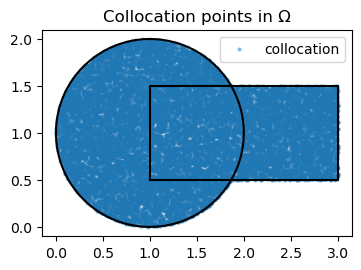

In [18]:
# 采样 Ω 内部点（只做一次就够）
key_pts  = jr.PRNGKey(SEED)
colloc   = sample_inside(key_pts, N_COL)

# --- 可视化 ---
import numpy as np, matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
plt.scatter(colloc[:,0], colloc[:,1], s=4, alpha=0.4, label="collocation")

# 画圆边界
theta = np.linspace(0, 2*np.pi, 200)
plt.plot(C[0] + R*np.cos(theta), C[1] + R*np.sin(theta), 'k')
# 画矩形边界
plt.plot([1,3,3,1,1], [0.5,0.5,1.5,1.5,0.5], 'k')
plt.gca().set_aspect("equal")
plt.title("Collocation points in Ω")
plt.legend(); plt.show()


In [19]:
# ---- Δu(x,y) 构造一次即可 ----
def make_lap(model):
    def u(p): return model(p).sum()           # scalar
    hess_b = jax.vmap(jax.hessian(u))
    @jax.jit
    def lap(pts): return jnp.trace(hess_b(pts), axis1=-2, axis2=-1)
    return lap

# ---- 单步优化 (optimizer 闭包) ----
def make_step(opt):
    @eqx.filter_jit
    def _step(model, state, batch, lap):
        loss, grads = eqx.filter_value_and_grad(lambda m,p: jnp.mean((-lap(p)-1)**2))(model, batch)
        updates, state = opt.update(grads, state, model)
        return eqx.apply_updates(model, updates), state, loss
    return _step


In [ ]:
def pde_loss(model, pts):
    """mean( ( -Δu - 1 )² )  over batch pts"""
    def u_scalar(p):
        return model(p).sum()             # scalar 0-D

    H = jax.vmap(jax.hessian(u_scalar))(pts)   # (B,2,2)
    lap = jnp.trace(H, axis1=-2, axis2=-1)     # (B,)
    return jnp.mean((-lap - 1.0) ** 2)

@eqx.filter_jit
def train_step(model, state, batch, optim):
    loss, grads = eqx.filter_value_and_grad(pde_loss)(model, batch)
    updates, state = optim.update(grads, state, model)
    model = eqx.apply_updates(model, updates)
    return model, state, loss


# --- main loop ----------------------------------------------------------
key  = jr.PRNGKey(SEED)
model = PINN(key)

import os, sys
# Optional: Add project root to PYTHONPATH if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
from train.trainer_single import train_single
model, loss_hist, _ = train_single(
    model=model,
    colloc=colloc,
    lr=1e-3,
    steps=3_000,
    pde_residual=pde_loss,
    batch_size=1_024,
    x_test=None,        # 没有真解就传 None
    u_exact=None,       # 
)



PINN: 100%|██████████| 3000/3000 [05:04<00:00,  9.84it/s]


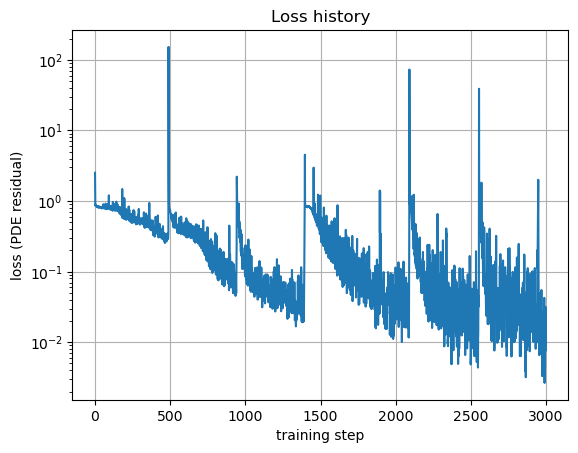

In [21]:
plt.figure()
plt.semilogy(loss_hist)
plt.xlabel("training step")
plt.ylabel("loss (PDE residual)")
plt.title("Loss history")
plt.grid(True); plt.show()


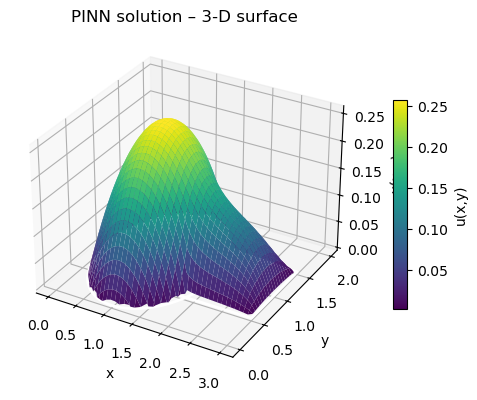

In [22]:
# ── 3-D surface plot ────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D        # noqa: F401

# 1 | 生成网格（适当降低分辨率避免 3-D 绘图太卡）
nx, ny = 161, 121
xx = jnp.linspace(0, 3, nx)
yy = jnp.linspace(0, 2, ny)
XX, YY = jnp.meshgrid(xx, yy, indexing="xy")
grid   = jnp.stack([XX.ravel(), YY.ravel()], -1)

# 2 | 预测 u(x,y)，并把域外点设为 NaN
u_pred = jax.vmap(model)(grid)
U      = jnp.where(inside(grid), u_pred, jnp.nan).reshape((ny, nx))

# 3 | 转成 NumPy（Matplotlib 需要）
Xn, Yn, Zn = map(np.asarray, (XX, YY, U))

# 4 | 绘制 3-D 曲面
fig = plt.figure(figsize=(7, 4))
ax  = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(Xn, Yn, Zn, linewidth=0, antialiased=True, cmap="viridis")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("u(x,y)")
ax.set_title("PINN solution – 3-D surface")
fig.colorbar(surf, shrink=0.6, aspect=15, label="u(x,y)")

# 叠加几何边界轮廓（白线）
theta = np.linspace(0, 2*np.pi, 400)
ax.plot(C[0] + R*np.cos(theta), C[1] + R*np.sin(theta), zs=0, zdir='z',
        color="w", lw=2)
ax.plot([1,3,3,1,1], [0.5,0.5,1.5,1.5,0.5], zs=0, zdir='z',
        color="w", lw=2)

plt.tight_layout()
plt.show()


### 

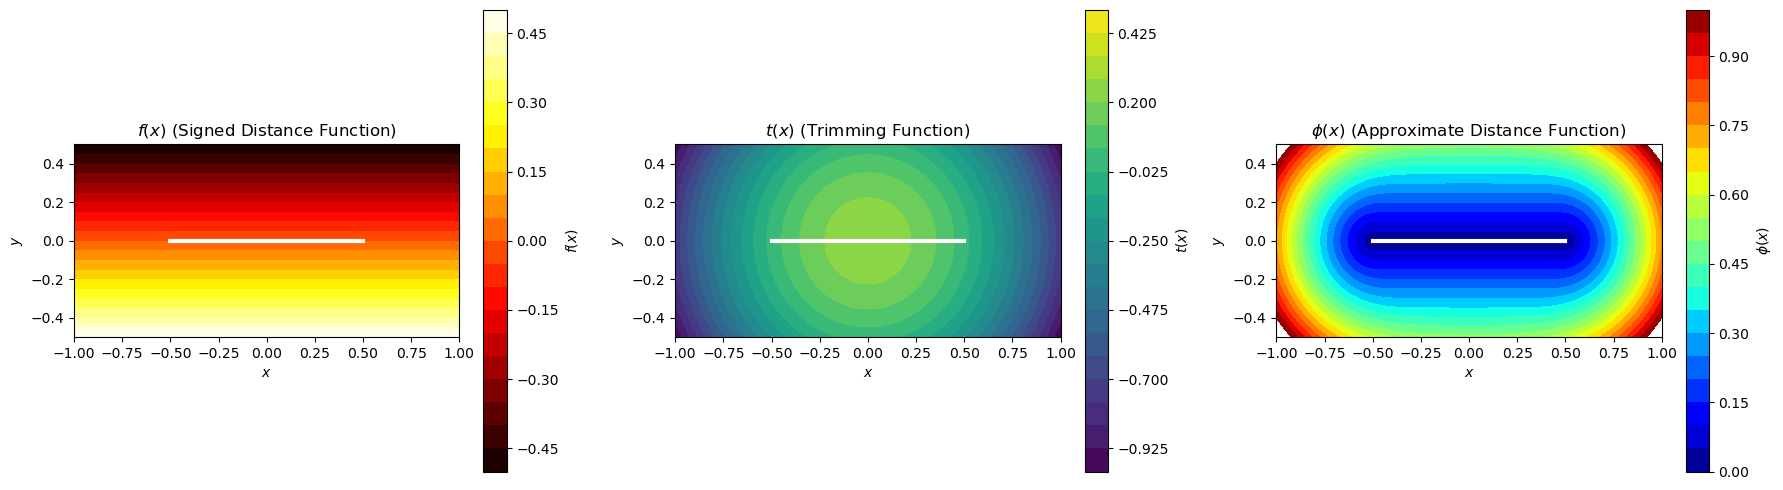

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math

# --- 之前定义的函数 (function_f4, function_t5, function_phi6) ---
# (确保这些函数定义在脚本的这个位置之前，或者从其他模块导入)

def calculate_segment_length_L(x1, x2):
    x1_coord, y1_coord = x1
    x2_coord, y2_coord = x2
    dx_segment = x2_coord - x1_coord
    dy_segment = y2_coord - y1_coord
    L_squared = dx_segment**2 + dy_segment**2
    if L_squared == 0:
        raise ValueError("线段长度 L 为零，因为 x1 和 x2 是同一点。")
    return math.sqrt(L_squared)

def function_f4(x_point, x1, x2):
    x_coord, y_coord = x_point
    x1_coord, y1_coord = x1
    x2_coord, y2_coord = x2
    L = calculate_segment_length_L(x1, x2)
    numerator = (x_coord - x1_coord) * (y2_coord - y1_coord) - \
                (y_coord - y1_coord) * (x2_coord - x1_coord)
    return numerator / L

def function_t5(x_point, x1, x2):
    x_coord, y_coord = x_point
    x1_coord, y1_coord = x1
    x2_coord, y2_coord = x2
    L = calculate_segment_length_L(x1, x2)
    xc_x = (x1_coord + x2_coord) / 2
    xc_y = (y1_coord + y2_coord) / 2
    norm_x_minus_xc_squared = (x_coord - xc_x)**2 + (y_coord - xc_y)**2
    L_div_2_squared = (L / 2)**2
    t_value = (1 / L) * (L_div_2_squared - norm_x_minus_xc_squared)
    return t_value

def function_phi6(x_point, x1, x2):
    f_value = function_f4(x_point, x1, x2)
    t_value = function_t5(x_point, x1, x2)
    varphi_squared_arg = t_value**2 + f_value**4
    varphi = math.sqrt(varphi_squared_arg)
    term2_numerator = varphi - t_value
    term2_squared = (term2_numerator / 2)**2
    phi_squared_arg = f_value**2 + term2_squared
    if phi_squared_arg < 0 and abs(phi_squared_arg) < 1e-9:
        phi_squared_arg = 0.0
    if phi_squared_arg < 0:
        raise ValueError(f"phi 的平方根参数为负: {phi_squared_arg}. "
                         f"f={f_value}, t={t_value}, varphi={varphi}")
    phi_value = math.sqrt(phi_squared_arg)
    return phi_value
# --- 函数定义结束 ---


# 1. 定义线段端点
segment_x1 = (-0.5, 0.0)
segment_x2 = (0.5, 0.0)

# 2. 创建网格点
x_vals = np.linspace(-1, 1, 200) # x 轴范围和点数
y_vals = np.linspace(-0.5, 0.5, 100) # y 轴范围和点数
X, Y = np.meshgrid(x_vals, y_vals)

# 初始化用于存储函数值的数组
F_values = np.zeros(X.shape)
T_values = np.zeros(X.shape)
PHI_values = np.zeros(X.shape)

# 3. 在每个网格点上计算函数值
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        current_point = (X[i, j], Y[i, j])
        try:
            F_values[i, j] = function_f4(current_point, segment_x1, segment_x2)
            T_values[i, j] = function_t5(current_point, segment_x1, segment_x2)
            PHI_values[i, j] = function_phi6(current_point, segment_x1, segment_x2)
        except ValueError as e:
            # 如果 L=0 (虽然这里不太可能，因为 segment_x1 和 segment_x2 是固定的)
            # 或者 phi 的参数为负，则标记为 NaN
            F_values[i, j] = np.nan
            T_values[i, j] = np.nan
            PHI_values[i, j] = np.nan
            print(f"在点 {current_point} 计算时出错: {e}")


# 4. 可视化
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # 1行3列的子图

# 绘制 f(x)
cf1 = axes[0].contourf(X, Y, F_values, levels=np.linspace(-0.5, 0.5, 21), cmap='hot')
fig.colorbar(cf1, ax=axes[0], label='$f(x)$')
axes[0].plot([segment_x1[0], segment_x2[0]], [segment_x1[1], segment_x2[1]], 'w-', linewidth=3) # 白色线段
axes[0].set_title('$f(x)$ (Signed Distance Function)')
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')
axes[0].set_aspect('equal', adjustable='box')

# 绘制 t(x)
# 根据示例图调整 t(x) 的 levels 和 colormap
# 示例图中 t(x) 范围大约是 -1 到 0.5
# t_levels = np.linspace(np.nanmin(T_values), np.nanmax(T_values), 21) # 自动范围
t_levels = np.linspace(-1, 0.5, 21)
cf2 = axes[1].contourf(X, Y, T_values, levels=t_levels, cmap='viridis') # 使用 viridis 颜色映射，或选择其他
fig.colorbar(cf2, ax=axes[1], label='$t(x)$')
axes[1].plot([segment_x1[0], segment_x2[0]], [segment_x1[1], segment_x2[1]], 'w-', linewidth=3)
axes[1].set_title('$t(x)$ (Trimming Function)')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_aspect('equal', adjustable='box')

# 绘制 phi(x)
# 示例图中 phi(x) 范围大约是 0 到 1
# phi_levels = np.linspace(np.nanmin(PHI_values), np.nanmax(PHI_values), 21) # 自动范围
phi_levels = np.linspace(0, 1.0, 21)
cf3 = axes[2].contourf(X, Y, PHI_values, levels=phi_levels, cmap='jet') # jet 颜色映射与示例相似
fig.colorbar(cf3, ax=axes[2], label='$\phi(x)$')
axes[2].plot([segment_x1[0], segment_x2[0]], [segment_x1[1], segment_x2[1]], 'w-', linewidth=3)
axes[2].set_title('$\phi(x)$ (Approximate Distance Function)')
axes[2].set_xlabel('$x$')
axes[2].set_ylabel('$y$')
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [ ]:
# 1. 定义线段端点
segment_x1 = (0.134,1.5)
segment_x2 = (1.866,1.5)
segment_x3 = (1.866,0.5)
segment_x4 = (0.134,0.5)
# 2. 创建网格点
x_vals = np.linspace(0, 3, 200) # x 轴范围和点数
y_vals = np.linspace(0, 2, 100) # y 轴范围和点数
X, Y = np.meshgrid(x_vals, y_vals)

# 初始化用于存储函数值的数组
F_values_1 = np.zeros(X.shape)
F_values_2 = np.zeros(X.shape)
F_values_3 = np.zeros(X.shape)
F_values_4 = np.zeros(X.shape)
T_values_1 = np.zeros(X.shape)
T_values_2 = np.zeros(X.shape)
T_values_3 = np.zeros(X.shape)
T_values_4 = np.zeros(X.shape)
PHI_value_1 = np.zeros(X.shape)
PHI_value_2 = np.zeros(X.shape)
PHI_value_3 = np.zeros(X.shape)
PHI_value_4 = np.zeros(X.shape)


# 3. 在每个网格点上计算函数值
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        current_point = (X[i, j], Y[i, j])
        try:
            F_values_1[i, j] = function_f4(current_point, segment_x1, segment_x2)
            T_values_1[i, j] = function_t5(current_point, segment_x1, segment_x2)
            PHI_values_1[i, j] = function_phi6(current_point, segment_x1, segment_x2)
        except ValueError as e:
            # 如果 L=0 (虽然这里不太可能，因为 segment_x1 和 segment_x2 是固定的)
            # 或者 phi 的参数为负，则标记为 NaN
            F_values[i, j] = np.nan
            T_values[i, j] = np.nan
            PHI_values[i, j] = np.nan
            print(f"在点 {current_point} 计算时出错: {e}")

In [ ]:
# 定义线段的端点
point_x1 = (2.0, 1.5)
point_x2 = (3.0, 1.5)
point_x3 = (3.0, 0.5)
point_x4 = (2.0, 0.5)
# 定义要计算函数值的点
point_x = (2.0, 1.0)

try:
    # 计算 f(x)
    f_val = function_f(point_x, point_x1, point_x2)
    print(f"f({point_x}) = {f_val}")

    # 计算 t(x)
    t_val = function_t(point_x, point_x1, point_x2)
    print(f"t({point_x}) = {t_val}")

    # 计算 phi(x)
    phi_val = function_phi(point_x, point_x1, point_x2)
    print(f"phi({point_x}) = {phi_val}")

    # 测试 L=0 的情况
    # coincident_point = (1.0, 1.0)
    # function_f4(point_x, coincident_point, coincident_point)


f((2.0, 1.0)) = 0.5
t((2.0, 1.0)) = -0.25
phi((2.0, 1.0)) = 0.5840112788501257


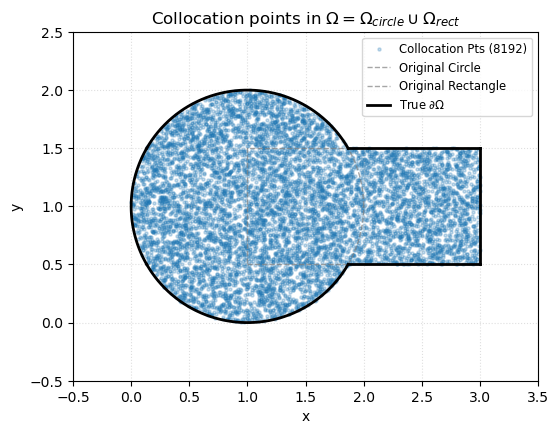

Sampled 8192 collocation points.


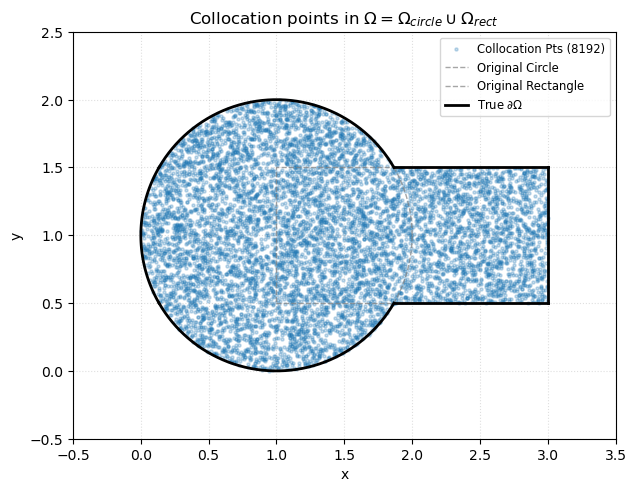

Sampled 8192 collocation points.


PINN:   0%|          | 0/2000 [00:00<?, ?it/s]


TypeError: Cannot interpret value of type <class 'jaxlib.xla_extension.PjitFunction'> as an abstract array; it does not have a dtype attribute

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax # For the optimizer
import numpy as np # For plotting meshgrid and some constants
import matplotlib.pyplot as plt
import os, sys


# Optional: Add project root to PYTHONPATH if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
from train.trainer_single import train_single
# --- JAX Configuration ---
jax.config.update("jax_enable_x64", True)

# --- Global Parameters for PINN Training ---
SEED = 1234
WIDTH = 64
DEPTH = 4
N_COL = 8192 # Can reduce for faster testing, e.g., 1024
M_R_FUNCTION_EXP = 4.0
EPSILON = 1e-9

# --- Geometric Parameters ---
CIRCLE_CENTER_JAX = jnp.array([1.0, 1.0])
CIRCLE_RADIUS_JAX = 1.0

# Individual components for rectangle
RECT_X_MIN_VAL, RECT_X_MAX_VAL = 1.0, 3.0
RECT_Y_MIN_VAL, RECT_Y_MAX_VAL = 0.5, 1.5

# Combined JAX arrays for rectangle corners (useful for some functions)
R_MIN_JAX_ARRAY = jnp.array([RECT_X_MIN_VAL, RECT_Y_MIN_VAL])
R_MAX_JAX_ARRAY = jnp.array([RECT_X_MAX_VAL, RECT_Y_MAX_VAL])

# Precise Intersection Points
SQRT_0_75 = jnp.sqrt(0.75)
X_INTERSECT_LEFT_JAX = 1.0 - SQRT_0_75
X_INTERSECT_RIGHT_JAX = 1.0 + SQRT_0_75

P_LT_JAX = jnp.array([X_INTERSECT_LEFT_JAX, RECT_Y_MAX_VAL])
P_RT_JAX = jnp.array([X_INTERSECT_RIGHT_JAX, RECT_Y_MAX_VAL])
P_LB_JAX = jnp.array([X_INTERSECT_LEFT_JAX, RECT_Y_MIN_VAL])
P_RB_JAX = jnp.array([X_INTERSECT_RIGHT_JAX, RECT_Y_MIN_VAL])
P_RECT_TR_JAX = jnp.array([RECT_X_MAX_VAL, RECT_Y_MAX_VAL])
P_RECT_BR_JAX = jnp.array([RECT_X_MAX_VAL, RECT_Y_MIN_VAL])

# --- Definitions for the 6 Boundary Primitives for Method A ---
PRIMITIVE_SEGMENTS_JAX = [ # Corrected: Use _JAX for consistency if these are fixed
    (P_RT_JAX, P_RECT_TR_JAX),
    (P_RECT_TR_JAX, P_RECT_BR_JAX),
    (P_RECT_BR_JAX, P_RB_JAX)
]

angle_RT = np.arctan2(P_RT_JAX[1] - CIRCLE_CENTER_JAX[1], P_RT_JAX[0] - CIRCLE_CENTER_JAX[0])
angle_LT = np.arctan2(P_LT_JAX[1] - CIRCLE_CENTER_JAX[1], P_LT_JAX[0] - CIRCLE_CENTER_JAX[0])
angle_LB = np.arctan2(P_LB_JAX[1] - CIRCLE_CENTER_JAX[1], P_LB_JAX[0] - CIRCLE_CENTER_JAX[0])
angle_RB = np.arctan2(P_RB_JAX[1] - CIRCLE_CENTER_JAX[1], P_RB_JAX[0] - CIRCLE_CENTER_JAX[0])

current_angle_A1_end = angle_LT if angle_LT >= angle_RT else angle_LT + 2 * np.pi
current_angle_A2_end = angle_LB if angle_LB >= angle_LT else angle_LB + 2 * np.pi # Corrected: should be angle_LT
# For A3: LB to RB
if angle_RB < angle_LB: # Ensure CCW for linspace by adding 2*pi to end angle if it "crossed" zero
    current_angle_A3_end = angle_RB + 2 * np.pi
else:
    current_angle_A3_end = angle_RB


PRIMITIVE_ARCS_JAX = [
    {'center': CIRCLE_CENTER_JAX, 'radius': CIRCLE_RADIUS_JAX, 'ep1': P_RT_JAX, 'ep2': P_LT_JAX,
     'plot_start_angle': angle_RT, 'plot_end_angle': current_angle_A1_end, 'id': 'A1_Top'},
    {'center': CIRCLE_CENTER_JAX, 'radius': CIRCLE_RADIUS_JAX, 'ep1': P_LT_JAX, 'ep2': P_LB_JAX,
     'plot_start_angle': angle_LT, 'plot_end_angle': current_angle_A2_end, 'id': 'A2_Left'}, # Corrected base angle for end
    {'center': CIRCLE_CENTER_JAX, 'radius': CIRCLE_RADIUS_JAX, 'ep1': P_LB_JAX, 'ep2': P_RB_JAX,
     'plot_start_angle': angle_LB, 'plot_end_angle': current_angle_A3_end, 'id': 'A3_Bottom'}
]
# (The rest of the phi function definitions remain the same as in the previous correct block)
# ... [Previous JAX phi functions: _func_f_val_segment_jax, _func_t_val_segment_jax, etc. ] ...
# Ensure these functions are present above the `combined_phi` definition

@jax.jit
def _func_f_val_segment_jax(point, p1, p2, segment_L_plus_eps):
    x, y = point[0], point[1]
    x1, y1 = p1[0], p1[1]
    x2, y2 = p2[0], p2[1]
    numerator = (x - x1) * (y2 - y1) - (y - y1) * (x2 - x1)
    return numerator / segment_L_plus_eps

@jax.jit
def _func_t_val_segment_jax(point, segment_L_plus_eps, xc_segment):
    x, y = point[0], point[1]
    xc_x, xc_y = xc_segment[0], xc_segment[1]
    norm_x_minus_xc_sq = (x - xc_x)**2 + (y - xc_y)**2
    L_div_2_sq = (segment_L_plus_eps / 2)**2
    return (1 / segment_L_plus_eps) * (L_div_2_sq - norm_x_minus_xc_sq)

@jax.jit
def _calculate_phi_from_ft_jax(f_val, t_val):
    varphi_sq_arg = t_val**2 + f_val**4
    varphi = jnp.sqrt(jnp.maximum(0., varphi_sq_arg))
    phi_term2_num = varphi - t_val
    phi_term2_sq = (phi_term2_num / 2)**2
    phi_sq_arg = f_val**2 + phi_term2_sq
    phi_val = jnp.sqrt(jnp.maximum(0., phi_sq_arg))
    return phi_val

@jax.jit
def get_phi_for_segment_primitive_jax(point, p1, p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    L_sq = dx**2 + dy**2
    segment_L = jnp.sqrt(L_sq) 
    segment_L_plus_eps = segment_L + EPSILON
    xc_segment = (p1 + p2) / 2.0
    f_val = _func_f_val_segment_jax(point, p1, p2, segment_L_plus_eps)
    t_val = _func_t_val_segment_jax(point, segment_L_plus_eps, xc_segment)
    return _calculate_phi_from_ft_jax(f_val, t_val)

@jax.jit
def _f_for_arc_primitive_jax(point, center, radius):
    radius_plus_eps = radius + EPSILON
    dist_sq_to_center = jnp.sum((point - center)**2)
    return (radius**2 - dist_sq_to_center) / (2 * radius_plus_eps)

@jax.jit
def _t_for_arc_primitive_jax(point, endpoint1, endpoint2):
    p1x, p1y = endpoint1[0], endpoint1[1]
    p2x, p2y = endpoint2[0], endpoint2[1]
    px, py = point[0], point[1]
    dx_chord = p2x - p1x
    dy_chord = p2y - p1y
    L_chord_sq = dx_chord**2 + dy_chord**2
    L_chord = jnp.sqrt(L_chord_sq) 
    L_chord_plus_eps = L_chord + EPSILON
    numerator = (px - p1x) * dy_chord - (py - p1y) * dx_chord
    return numerator / L_chord_plus_eps
    
@jax.jit
def get_phi_for_arc_primitive_jax(point, center, radius, arc_ep1, arc_ep2):
    f_val = _f_for_arc_primitive_jax(point, center, radius)
    t_val = _t_for_arc_primitive_jax(point, arc_ep1, arc_ep2)
    return _calculate_phi_from_ft_jax(f_val, t_val)

@jax.jit
def phi_total_method_A_jax(p_array):
    phi_s1 = get_phi_for_segment_primitive_jax(p_array, PRIMITIVE_SEGMENTS_JAX[0][0], PRIMITIVE_SEGMENTS_JAX[0][1])
    phi_s2 = get_phi_for_segment_primitive_jax(p_array, PRIMITIVE_SEGMENTS_JAX[1][0], PRIMITIVE_SEGMENTS_JAX[1][1])
    phi_s3 = get_phi_for_segment_primitive_jax(p_array, PRIMITIVE_SEGMENTS_JAX[2][0], PRIMITIVE_SEGMENTS_JAX[2][1])
    
    phi_a1 = get_phi_for_arc_primitive_jax(p_array, PRIMITIVE_ARCS_JAX[0]['center'], PRIMITIVE_ARCS_JAX[0]['radius'], PRIMITIVE_ARCS_JAX[0]['ep1'], PRIMITIVE_ARCS_JAX[0]['ep2'])
    phi_a2 = get_phi_for_arc_primitive_jax(p_array, PRIMITIVE_ARCS_JAX[1]['center'], PRIMITIVE_ARCS_JAX[1]['radius'], PRIMITIVE_ARCS_JAX[1]['ep1'], PRIMITIVE_ARCS_JAX[1]['ep2'])
    phi_a3 = get_phi_for_arc_primitive_jax(p_array, PRIMITIVE_ARCS_JAX[2]['center'], PRIMITIVE_ARCS_JAX[2]['radius'], PRIMITIVE_ARCS_JAX[2]['ep1'], PRIMITIVE_ARCS_JAX[2]['ep2'])
    
    phi_values = jnp.array([phi_s1, phi_s2, phi_s3, phi_a1, phi_a2, phi_a3])
        
    phi_values_plus_eps = phi_values + EPSILON 
    sum_inv_phi_m = jnp.sum((1.0 / phi_values_plus_eps)**M_R_FUNCTION_EXP)
    is_on_boundary = jnp.any(phi_values < EPSILON) 
    combined_phi_val = (sum_inv_phi_m + EPSILON)**(-1.0 / M_R_FUNCTION_EXP)
    return jnp.where(is_on_boundary, 0.0, combined_phi_val)

combined_phi = phi_total_method_A_jax

@jax.jit
def d_circle_for_sampling(p):
    return CIRCLE_RADIUS_JAX - jnp.linalg.norm(p - CIRCLE_CENTER_JAX)

@jax.jit
def d_rect_for_sampling(p): # Corrected to use R_MIN_JAX_ARRAY and R_MAX_JAX_ARRAY
    dx = jnp.minimum(p[0] - R_MIN_JAX_ARRAY[0], R_MAX_JAX_ARRAY[0] - p[0])
    dy = jnp.minimum(p[1] - R_MIN_JAX_ARRAY[1], R_MAX_JAX_ARRAY[1] - p[1])
    return jnp.minimum(dx, dy)

@jax.jit
def d_union_for_sampling(p):
    return jnp.maximum(d_circle_for_sampling(p), d_rect_for_sampling(p))

inside_vmap = jax.jit(jax.vmap(lambda p_single: d_union_for_sampling(p_single) > -EPSILON))

def sample_inside(key, n, fac=4):
    actual_omega_xmin = 0.0; actual_omega_xmax = 3.0
    actual_omega_ymin = 0.0; actual_omega_ymax = 2.0
    bbox_min_tight = jnp.array([actual_omega_xmin, actual_omega_ymin])
    bbox_max_tight = jnp.array([actual_omega_xmax, actual_omega_ymax])
    pts_list = []
    current_need = n
    current_key = key
    max_cand_per_iter = max(1000, fac * n // 2 if n > 100 else fac*n )
    loop_iters = 0; max_loop_iters = n * 3 + 10

    while current_need > 0 and loop_iters < max_loop_iters:
        loop_iters += 1
        current_key, sk = jr.split(current_key)
        num_cand_this_iter = min(max_cand_per_iter, fac * current_need + 100)
        cand = jr.uniform(sk, (num_cand_this_iter, 2), minval=bbox_min_tight, maxval=bbox_max_tight)
        selected_points = cand[inside_vmap(cand)]
        num_selected = selected_points.shape[0]
        if num_selected > 0:
            take_num = min(num_selected, current_need)
            pts_list.append(selected_points[:take_num])
            current_need -= take_num
    if not pts_list:
        print(f"Warning: sample_inside collected 0 points after {loop_iters} iterations. Returning random points.")
        current_key, sk = jr.split(current_key)
        return jr.uniform(sk, (n, 2), minval=bbox_min_tight, maxval=bbox_max_tight)
    
    # Ensure exactly n points if more were collected due to batching
    final_pts = jnp.concatenate(pts_list, axis=0)
    if final_pts.shape[0] > n:
        key_final_shuffle, _ = jr.split(current_key) # Use the latest key
        final_pts = jr.permutation(key_final_shuffle, final_pts, axis=0)[:n]
    elif final_pts.shape[0] < n : # Should ideally not happen if loop is effective
        print(f"Warning: sample_inside collected {final_pts.shape[0]} points, needed {n}. Padding with random.")
        key_padding, _ = jr.split(current_key)
        padding_needed = n - final_pts.shape[0]
        padding_pts = jr.uniform(key_padding, (padding_needed, 2), minval=bbox_min_tight, maxval=bbox_max_tight)
        final_pts = jnp.concatenate([final_pts, padding_pts], axis=0)

    return final_pts


class PINN(eqx.Module):
    mlp: eqx.nn.MLP
    def __init__(self, key):
        self.mlp = eqx.nn.MLP(
            in_size=2, out_size=1, width_size=WIDTH, depth=DEPTH,
            key=key, activation=jax.nn.tanh
        )

    @jax.jit
    def __call__(self, x_point): 
        v_mlp = self.mlp(x_point) 
        v = v_mlp[0] 
        phi_w = combined_phi(x_point) 
        return phi_w * v

key_pts  = jr.PRNGKey(SEED)
colloc   = sample_inside(key_pts, N_COL)

# --- 可视化采样点 (使用 NumPy 版本的几何参数) ---
C_np = np.array(CIRCLE_CENTER_JAX)
R_np = float(CIRCLE_RADIUS_JAX)
# Corrected: Use the combined JAX arrays for R_MIN/R_MAX for consistency
R_MIN_np_array = np.array(R_MIN_JAX_ARRAY) 
R_MAX_np_array = np.array(R_MAX_JAX_ARRAY)

plt.figure(figsize=(6,5))
plt.scatter(colloc[:,0], colloc[:,1], s=5, alpha=0.25, label=f"Collocation Pts ({N_COL})")
theta_plot_circle = np.linspace(0, 2*np.pi, 200)
plt.plot(C_np[0] + R_np*np.cos(theta_plot_circle), C_np[1] + R_np*np.sin(theta_plot_circle), 'gray', linestyle='--', alpha=0.7, linewidth=1, label="Original Circle")
# Use R_MIN_np_array and R_MAX_np_array for plotting rectangle
rect_plot_x_coords = [R_MIN_np_array[0], R_MAX_np_array[0], R_MAX_np_array[0], R_MIN_np_array[0], R_MIN_np_array[0]]
rect_plot_y_coords = [R_MIN_np_array[1], R_MIN_np_array[1], R_MAX_np_array[1], R_MAX_np_array[1], R_MIN_np_array[1]]
plt.plot(rect_plot_x_coords, rect_plot_y_coords, 'gray', linestyle='--', alpha=0.7, linewidth=1, label="Original Rectangle")

boundary_label_added_main = False
num_arc_pts_main = 50
for seg_param_main in PRIMITIVE_SEGMENTS_JAX:
    p1_main, p2_main = seg_param_main[0], seg_param_main[1]
    plt.plot(np.array([p1_main[0], p2_main[0]]), np.array([p1_main[1], p2_main[1]]), 'k-', linewidth=2.0, 
             label='True $\partial\Omega$' if not boundary_label_added_main else "")
    boundary_label_added_main = True # ensure label is added only once
for arc_param_main in PRIMITIVE_ARCS_JAX:
    s_angle_main, e_angle_main = arc_param_main['plot_start_angle'], arc_param_main['plot_end_angle']
    angles_plot_main = np.linspace(s_angle_main, e_angle_main, num_arc_pts_main)
    arc_x_main = np.array(arc_param_main['center'][0] + arc_param_main['radius'] * np.cos(angles_plot_main))
    arc_y_main = np.array(arc_param_main['center'][1] + arc_param_main['radius'] * np.sin(angles_plot_main))
    plt.plot(arc_x_main, arc_y_main, 'k-', linewidth=2.0, 
             label='True $\partial\Omega$' if not boundary_label_added_main else "")
    boundary_label_added_main = True # ensure label is added only once
if boundary_label_added_main: plt.legend(fontsize='small', loc='upper right')


plt.gca().set_aspect("equal")
plt.title("Collocation points in $\Omega = \Omega_{circle} \cup \Omega_{rect}$")
plt.xlabel("x"); plt.ylabel("y")
plot_x_range_vis = (-0.5, 3.5)
plot_y_range_vis = (-0.5, 2.5)
plt.xlim(plot_x_range_vis); plt.ylim(plot_y_range_vis) # Use vis ranges
plt.grid(True, linestyle=':', alpha=0.4)
plt.show()


def pde_loss(model_instance, batch_of_points):
    u_scalar_fn = lambda p_single: model_instance(p_single)
    hessian_u_batch_fn = jax.vmap(jax.hessian(u_scalar_fn))
    H_batch = hessian_u_batch_fn(batch_of_points)
    lap_u_batch = jnp.trace(H_batch, axis1=-2, axis2=-1)
    residual = -lap_u_batch - 1.0
    return jnp.mean(residual ** 2)



# --- Main Execution ---
if __name__ == '__main__':
    # Define plotting ranges here so they are available for all plots

    # 1. Sample Collocation Points
    key_sampling = jr.PRNGKey(SEED)
    collocation_data = sample_inside(key_sampling, N_COL)
    print(f"Sampled {collocation_data.shape[0]} collocation points.")

    # 2. Visualize Collocation Points and True Boundary
    C_np = np.array(CIRCLE_CENTER_JAX)
    R_np = float(CIRCLE_RADIUS_JAX)
    R_MIN_np_array = np.array(R_MIN_JAX_ARRAY) 
    R_MAX_np_array = np.array(R_MAX_JAX_ARRAY)

    plt.figure(figsize=(7,6)) # Adjusted for better visibility
    plt.scatter(collocation_data[:,0], collocation_data[:,1], s=5, alpha=0.25, label=f"Collocation Pts ({N_COL})")
    theta_plot_circle = np.linspace(0, 2*np.pi, 200)
    plt.plot(C_np[0] + R_np*np.cos(theta_plot_circle), C_np[1] + R_np*np.sin(theta_plot_circle), 'gray', linestyle='--', alpha=0.7, linewidth=1, label="Original Circle")
    rect_plot_x_coords = [R_MIN_np_array[0], R_MAX_np_array[0], R_MAX_np_array[0], R_MIN_np_array[0], R_MIN_np_array[0]]
    rect_plot_y_coords = [R_MIN_np_array[1], R_MIN_np_array[1], R_MAX_np_array[1], R_MAX_np_array[1], R_MIN_np_array[1]]
    plt.plot(rect_plot_x_coords, rect_plot_y_coords, 'gray', linestyle='--', alpha=0.7, linewidth=1, label="Original Rectangle")

    boundary_label_added_main = False
    num_arc_pts_main = 50
    for seg_param_main in PRIMITIVE_SEGMENTS_JAX: 
        p1_main, p2_main = seg_param_main[0], seg_param_main[1]
        plt.plot(np.array([p1_main[0], p2_main[0]]), np.array([p1_main[1], p2_main[1]]), 'k-', linewidth=2.0, 
                 label='True $\partial\Omega$' if not boundary_label_added_main else "")
        if not boundary_label_added_main: boundary_label_added_main = True 
    for arc_param_main in PRIMITIVE_ARCS_JAX:
        s_angle_main, e_angle_main = arc_param_main['plot_start_angle'], arc_param_main['plot_end_angle']
        angles_plot_main = np.linspace(s_angle_main, e_angle_main, num_arc_pts_main)
        arc_x_main = np.array(arc_param_main['center'][0] + arc_param_main['radius'] * np.cos(angles_plot_main))
        arc_y_main = np.array(arc_param_main['center'][1] + arc_param_main['radius'] * np.sin(angles_plot_main))
        plt.plot(arc_x_main, arc_y_main, 'k-', linewidth=2.0, 
                 label='True $\partial\Omega$' if not boundary_label_added_main else "")
        if not boundary_label_added_main: boundary_label_added_main = True
    if boundary_label_added_main: plt.legend(fontsize='small', loc='upper right')

    plt.gca().set_aspect("equal")
    plt.title("Collocation points in $\Omega = \Omega_{circle} \cup \Omega_{rect}$")
    plt.xlabel("x"); plt.ylabel("y")
    plt.xlim(plot_x_range_vis); plt.ylim(plot_y_range_vis) # Now defined
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.show()
    
    key_sampling = jr.PRNGKey(SEED)
    collocation_data = sample_inside(key_sampling, N_COL)
    print(f"Sampled {collocation_data.shape[0]} collocation points.")

    key_model_init_main = jr.PRNGKey(SEED + 1)
    pinn_model_instance = PINN(key_model_init_main)


    trained_pinn_model, loss_history_log, _ = train_single(
    model=pinn_model_instance,
    colloc=collocation_data,
    lr=1e-3,
    steps=2000,
    pde_residual=pde_loss,
    batch_size=1024,
    x_test=None,
    u_exact=None,
    save_dir=None,
    checkpoint_every=0,)

    plt.figure(figsize=(8,4))
    plt.plot(loss_history_log)
    plt.xlabel("Training Epoch")
    plt.ylabel("Average Loss")
    plt.yscale("log")
    plt.title("Loss History during PINN Training")
    plt.grid(True)
    plt.show()
    print("Script finished. Trained model is in 'trained_pinn_model'.")